## Sizing of Energy Opportunity

We will start by setting up a convenient environment to run our code, by installing the adequate packages and defining  the IPython interpreter that will import matplotlib and NumPy modules to get access to their functions. 

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Curtailement Model

The first part focuses on generating the amount of energy currently curtailed annually across the Orkney Isles. Our approach was to first establish the relationship between potential power and wind speed using the turbine data provided. Once we determine the parameters to model the power output based on historical data, we will use it to create a function that converts the wind speed data from 2017 to 2018 to its corresponding potential power output while keeping in mind the turbines limitation. However, some challenges were met along the way, since a high number of data concerning the weather conditions (wind speed) were missing from 2017 to 2018 we decided to webscrape them from a certified website. The recovered data was then used to fill the missing dates and calculate the potential power generated from 2017 to 2018. Before calculating the annually curtailed energy in orkney isles, we still need to aggregate the local demand so it includes the demand for 10,385 households in the correct measure (kWh). Finally, annual curtailment was determined by subtracting the total local demand and exported energy to the total power generated annually. A detailed methodology of the steps followed are described below as well as the assumptions taken.

### Wind capacity parameter

The first step here is to find the wind capacity parameter that maps the wind-power relationship. In fact, The power generated by wind turbines can be represented by a function of wind speed and other factors concerning the engineering structure of the turbine. This relationship is illustrated by the following equation:

$$ P = \frac{1}{2} \rho V^3 A$$

Where P is the power of the wind (in Watts); \
$\rho$ is the density of the air (in $kg/m^3$); \
V is the velocity of the wind measured in m/s; \
A is the area swept by the circular rotor in square meters; \
r and the radius of the rotor (in meters); 

Since we are not in possesion of the above mentioned parameters, we can embbed them in a variable $k$ (wind capacity) that can be determined through data manipulation. The relationship between power output and wind speed now becomes:

$$P = k \times V^3$$

$$k = \frac{P}{V^3}$$

In the steps below, we will walk through some data exploration and analysis to correctly determine the wind capacity and ensure that we have all the data to complete this milestone. Lets have a first look at the telemetry data given and explore its components.

In [89]:
# get turbine telemetry
dmd = pd.read_csv('/Users/macbookpro/Desktop/Analytics in Business Capstone Project/Case study - Heat Smart Orkney/data/residential_demand.csv', parse_dates=[0], index_col=0)
tt = pd.read_csv('/Users/macbookpro/Desktop/Analytics in Business Capstone Project/Case study - Heat Smart Orkney/data/turbine_telemetry.csv', parse_dates=[0], index_col=0)

In [9]:
# it looks like the data is sampled at nearly 1 minute intervals
tt.head(10)

,Power_kw,Setpoint_kw,Wind_ms
Timestamp,,,
2015-05-28 00:00:23,80.0,900.0,4.9
2015-05-28 00:01:23,78.0,900.0,5.4
2015-05-28 00:02:23,52.0,900.0,4.9
2015-05-28 00:03:23,57.0,900.0,4.6
2015-05-28 00:04:23,54.0,900.0,4.6
2015-05-28 00:05:23,44.0,900.0,4.5
2015-05-28 00:06:23,62.0,900.0,4.5
2015-05-28 00:07:23,51.0,900.0,4.1
2015-05-28 00:08:23,155.0,900.0,6.4


In [17]:
# how to find out if that hypothesis is true? 
dt = pd.Series(tt.index).diff()
one_min = pd.Timedelta(minutes=1)
perc = (dt == one_min).sum() / len(dt)
abv =(tt.Power_kw > tt.Setpoint_kw).sum() / len(tt)

print(f'The timeseries data provided is not complete and include a maximum gap of {dt.max()}.')
print(f'The minimum interval of time between measurements seems to be of {dt.min()}, i.e. 1 minute interval.')
print(f'Moreover {round(perc*100,3)}% of the data are measured at a 1 minute interval.')
print(f'Approximately {round(abv*100,3)}% of the time, the power output is above the setpoint')

The timeseries data provided is not complete and include a maximum gap of 98 days 00:01:07.
The minimum interval of time between measurements seems to be of 0 days 00:00:01, i.e. 1 minute interval.
Moreover 98.308% of the data are measured at a 1 minute interval.
Approximately 13.005% of the time, the power output is above the setpoint


In [21]:
print('Below is a statistical summary of the telemetry dataset for each column respectively')
tt.describe()

Below is a statistical summary of the telemetry dataset for each column respectively


,Power_kw,Setpoint_kw,Wind_ms
count,1.066934e+06,1.066921e+06,1.066931e+06
mean,3.671871e+02,8.106578e+02,9.955093e+00
std,3.399636e+02,2.615071e+02,5.453944e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.100000e+01,9.000000e+02,6.100000e+00
50%,2.510000e+02,9.000000e+02,9.000000e+00
75%,7.040000e+02,9.000000e+02,1.240000e+01
max,9.380000e+02,9.000000e+02,4.720000e+01


Before directly using the dataset to model the wind-power relationship, it would be interesting to visualise the wind vs power profile to have a better idea of the pattern and check that we did not miss any hidden pattern that cannot be found from the above statistics.

Text(0, 0.5, 'Power generated in kWh')

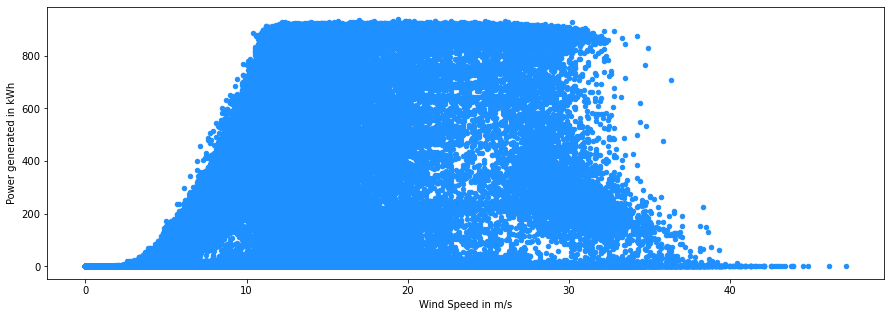

In [62]:
# to avoid replotting everytime you re-run the notebook, I suggest caching the image
# `alpha` -- opacity
tt.plot.scatter('Wind_ms', 'Power_kw', alpha=1, figsize=(15, 5), color = 'dodgerblue') # alpha here is important
plt.xlabel('Wind Speed in m/s')
plt.ylabel('Power generated in kWh')

As we can see, since the measurements are recorded every minute, we have a very large dataset, meaning that we cannot clearly observe the true relationship due to data clustering and superposition. An option here would be to increase the transparency of the data marks to determine which part of the graph is still the most stacked and hence the most likely to represent the true relationship between wind and power.

Text(0, 0.5, 'Power generated in kWh')

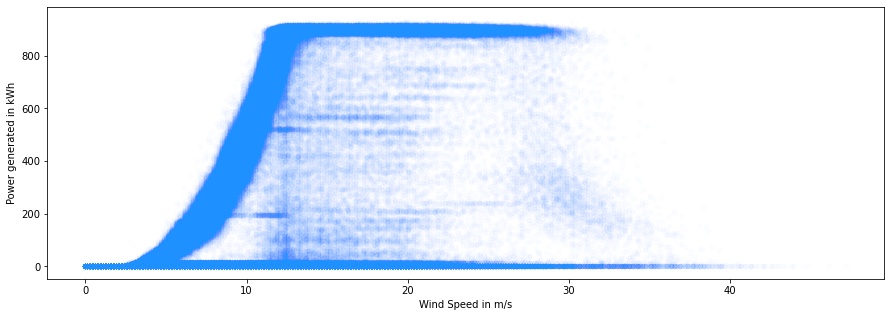

In [63]:
# to avoid replotting everytime you re-run the notebook, I suggest caching the image
tt.plot.scatter('Wind_ms', 'Power_kw', alpha=0.01, figsize=(15, 5), color = 'dodgerblue') # alpha here is important
plt.xlabel('Wind Speed in m/s')
plt.ylabel('Power generated in kWh')

In effect, we now have a better look at the wind profile, where we can see an exponential growth/increase in the power generated starting a wind speed of 4 m/s to 12.5 m/s after which the power generated seems to reach its maximum value of 900 kW. We also notice a lot of data points that shows 0 power generated and these may be some outliers in the data (the turbines are turned off or defaulted). The next step would be to remove all these outliers and clean our data to only extract valuable data, truly representative of the wind-power relationship.  

Hence, we decided to query all the data where the setpoint is at its max (meaning that no energy is curtailed) and drop any record where the wind speed is fast enough for power production but there is no power (turbine is probably manually switched off).

In [70]:
# Some examples:
# we only want to use data when the turbine was not constrained
# there are two options here -- queries and filter 
# query is more SQL-ish
df = tt.query('Setpoint_kw==900').copy()

# remove data points when the wind speed is fast enough for power production but there is no power; turbine is probably manually switched off here
df.loc[((df.Wind_ms >= 5) & (df.Power_kw.abs() <= 1e-5))] = np.nan

# remove all missing values from the dataframe
df = df.dropna(0, inplace=False)

Text(0, 0.5, 'Power generated in kWh')

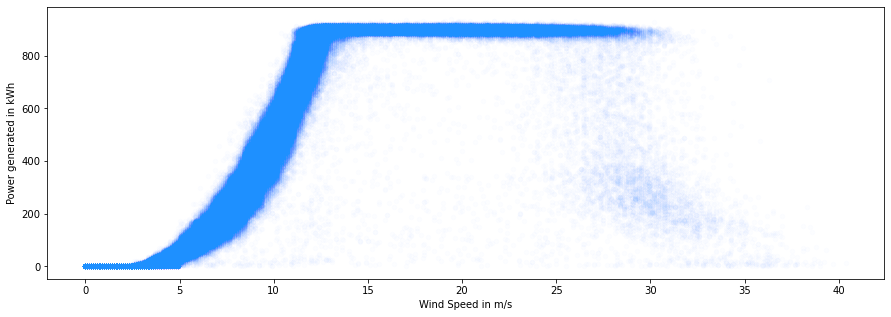

In [71]:
# let's attempt the scatter plot again
df.plot.scatter('Wind_ms', 'Power_kw', alpha=0.01, figsize=(15, 5), color ='dodgerblue') # a lot cleaner!
plt.xlabel('Wind Speed in m/s')
plt.ylabel('Power generated in kWh')

Indeed, the plot is now way cleaner and we are able to distinguish the true wind-power relationship: exponential increase from 4 m/s to 12.5 m/s and stagnation of the power generated from 12.5 m/s to 25-30m/s where the turbine engineering limits the production of any power. Note that there is no power generated below 4 m/s. All these limitations should be implemented when creating the function that model power generation from wind data.

We can use the cleaned data to fit the equation and find the unknown parameter for later use. In order to fit the data correctly, we should start by creating an adequate lookup table that will map the scatter plot into a curve line. Once obtained, we only have to divide the power output by the cube of the wind speed (as shown in the equation formulated above) to get the wind capacity. We will recreate the power vs wind profile by assigning 0.2 interval bins, with a max wind speed of 12.5 $m/s$ since the generated power seems to reach its peak at this value, and interpolate the bins using the median.

In [47]:
bins_ = [round(_, 2) for _ in arange(0, 17, .2)] # <-- step
bins = list(zip(bins_, bins_[1:]))

def bin_assigner(x, bins=bins):
    for k, (a, b) in enumerate(bins):
        if x >= a and x < b:
            return bins[k]
    else:
        return (17, np.inf) 
    
gp_ = df.copy()
gp_['bins'] = gp_.Wind_ms.apply(bin_assigner)

p_w = gp_[['Power_kw', 'bins']].groupby('bins')
power_med = p_w.quantile(0.5)

Text(0, 0.5, 'Power generated in kWh')

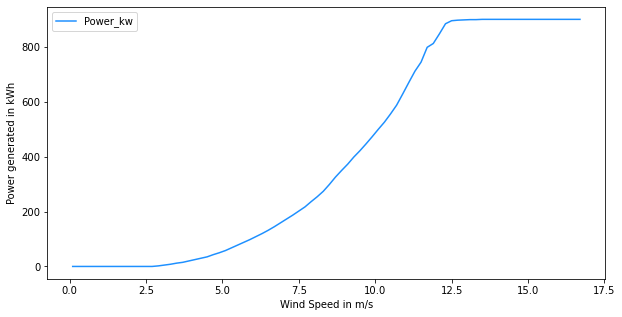

In [59]:
wind_spd = []
for k, (a, b) in enumerate(power_med.index):
    idx = (a+b)/2
    wind_spd.append(idx)

power_med['wind_ms'] = wind_spd
power_med.plot('wind_ms', 'Power_kw', figsize=(10, 5), color = 'dodgerblue')
plt.xlabel('Wind Speed in m/s')
plt.ylabel('Power generated in kWh')

Now that we have a good understanding and visual of the wind profile generated through cleaning and manipulation of provided data, we can determine the wind capacity using the formula provided. Note that the wind capacity will be calculated from the data located between 4 and 12.5 m/s, where the power output exhibit an exponential increase. Including data below and above this interval would skew the calculation and provide a wrong approximation of the parameter we are looking to determine. Thus, we start by filtering the data to only contain wind speed that ranges between this interval, and create a new column that takes the cube of each record's wind speed respectively. Finally to obtain the wind capacity of each measurement, we create a last column that divides the power output by the cube of the wind speed. The only step left is to aggregate the wind capacity column by the mean to obtain its approximate value along our dataset.

In [80]:
power_med['wind_ms^3'] = power_med.wind_ms**3

# only extract the values where wind is higher than 5 m/s and smaller than 17 m/s
power_med_k = power_med[(power_med.wind_ms >= 4) & (power_med.wind_ms <= 12.4)]
power_med_k['k'] = power_med_k.Power_kw/power_med_k['wind_ms^3']
k_parameter = power_med_k.k.mean()
power_med_k[10:20]

,Power_kw,wind_ms,wind_ms^3,k
bins,,,,
"(6.0, 6.2)",109.0,6.1,226.981,0.480216
"(6.2, 6.4)",120.0,6.3,250.047,0.479910
"(6.4, 6.6)",132.0,6.5,274.625,0.480655
"(6.6, 6.8)",145.0,6.7,300.763,0.482107
"(6.8, 7.0)",159.0,6.9,328.509,0.484005
"(7.0, 7.2)",173.0,7.1,357.911,0.483360
"(7.2, 7.4)",187.0,7.3,389.017,0.480699
"(7.4, 7.6)",202.0,7.5,421.875,0.478815
"(7.6, 7.8)",217.0,7.7,456.533,0.475322


In [79]:
print(f'The approximate value of the wind capacity is {round(k_parameter,3)}')

The approximate value of the wind capacity is 0.471


Now that we have found the wind capacity parameter, we need to check that we have all the data from 2017 to 2018 for both the telemetry and the demand datasets. If there are any missing value, we will need to develop a strategy to recover these data points in order to reach the most accurate results. We will check that the data is complete by generating a correct time series starting from 2017 to 2018 with an interval of 30 minutes between each date and compare the length of the true time serie and the given ones.

In [91]:
# generate time series data to find any missing value
true_dates = (pd.DataFrame(columns=['date'],
                  index=pd.date_range(dmd.index[0], dmd.index[-1],
                                      freq='30T')).index.strftime('%Y-%m-%d %H:%M:%S')).tolist()
print(f'Is the demand dataset complete? {len(true_dates) == len(dmd)}')

Is the demand dataset complete? True


Since we did not find any missing value in the demand data, we need to check that the dates when the telemetry data was extracted matches the corresponding demand date. In other words, we should ensure that the corresponding wind speed data for each of the demand data is available from 2017 to 2018. Moreover, since the residential demand data was extracted every 30-minute interval whereas the wind speed measurements are taken every 1-minute, we have to aggregate the wind speed data into 30-minute intervals by taking the average of thirty consecutive sample/measurements.

We start by extracting the telemetry data (that contains the wind speed) from 2017 to 2018, and then compare it to the length of a true time serie with 1 minute interval.

In [95]:
# filter telemetry data only for dates between 2017 and 2018
tt_17_18 = tt[(tt.index >= ('2017-01-01 00:00:00')) & (tt.index < '2018-01-02 00:00:00')]

# create dates ranging from 2017 to 2018 to check how many missing values we have 
true_dates = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range('2017-01-01 00:00:00', '2018-01-01 23:59:00',
                                      freq='1T')).index.strftime('%Y-%m-%d %H:%M:%S'))

# average provided data by minutes for easier manipulation
tt_1m = tt_17_18.groupby(pd.Grouper(freq='1Min')).aggregate(numpy.mean)

print(f"The provided data has {len(tt_17_18)} entries from 2017 to 2018 instead of {len(true_dates)}, leaving {len(true_dates)-len(tt_17_18)} null values")

The provided data has 497574 entries from 2017 to 2018 instead of 527040, leaving 29466 null values


Since the local demand data is given in a 30 minute interval we could narrow the unavailable data by aggregating the telemetry data every 30 minute interval. The next important step here is to correctly determine the intervals where the wind records are missing to optimise the amount of record we should extract from the web to replace the missing values. One way to find these intervals is by creating a new column in the telemetry table that will assign a cumulative group number to the samples of data that are of the same type. i.e, every series of consecutive data of the same type will be assigned the same group number. If the first three rows does not have missing data, they will be assigned the group 1 until a new record of type NA appears, then the next rows with type NA will be assigned to group 2 until a record of type integer (available data) appears and its consecutive rows of the same type are assigned to group 3 and so on. Since the first chunk of samples are available, our algorithm will assign odd number groups to the interval where data is available and even numbers to the data that is unavailable.

A sample of the data set where the type of the data passes from integer to NA is at rows 4446 and 4447, the extracted rows below is an example of the methodology followed by the algorithm.

In [116]:
# Since the local demand data is given in a 30 minute interval we could narrow the unavailable data by group the data 
# for every 30 minute interval
tt_30m = tt_17_18.groupby(pd.Grouper(freq='30Min')).aggregate(numpy.mean)

# lets extract the timestamp with null value and replace them with historical data available from the web 
null_dates = tt_30m[tt_30m.isna().any(axis=1)].index

# we can also create a table that will display the interval where the data is available
tt_30m['group'] = (pd.isnull(tt_30m.Wind_ms).astype(int).diff() != 0).cumsum()
tt_30m_in = tt_30m.reset_index()
tt_30m_in[4443:4451]

,Timestamp,Power_kw,Setpoint_kw,Wind_ms,group
4443,2017-04-03 13:30:00,643.800000,900.000000,10.910000,1
4444,2017-04-03 14:00:00,541.033333,824.133333,10.366667,1
4445,2017-04-03 14:30:00,635.633333,900.000000,10.853333,1
4446,2017-04-03 15:00:00,566.777778,900.000000,10.555556,1
4447,2017-04-03 15:30:00,NaN,NaN,NaN,2
4448,2017-04-03 16:00:00,NaN,NaN,NaN,2
4449,2017-04-03 16:30:00,NaN,NaN,NaN,2
4450,2017-04-03 17:00:00,NaN,NaN,NaN,2


Now that groups were assigned to each intervals, we can aggregate the data to obtain the first and last entry of each interval and its type. The type column llabels the intervals into available and unavailable, where available refers to the odd group numbers and unavailable refers to even group numbers. The 11 alternating intervals detected are shown in the table below with its first and last date.

In [1314]:
interval = tt_30m_in.groupby('group')['Timestamp'].agg(['first','last'])
types = pd.Categorical(['Unavailable', 'Available'])
interval['type'] = types[interval.index % 2]
interval

,first,last,type
group,,,
1,2017-01-01 00:00:00,2017-04-03 15:00:00,Available
2,2017-04-03 15:30:00,2017-04-24 02:30:00,Unavailable
3,2017-04-24 03:00:00,2017-05-17 02:00:00,Available
4,2017-05-17 02:30:00,2017-05-17 08:00:00,Unavailable
5,2017-05-17 08:30:00,2017-11-09 02:00:00,Available
6,2017-11-09 02:30:00,2017-11-09 03:00:00,Unavailable
7,2017-11-09 03:30:00,2017-12-13 22:00:00,Available
8,2017-12-13 22:30:00,2017-12-14 05:00:00,Unavailable
9,2017-12-14 05:30:00,2017-12-15 12:30:00,Available


Finally, since only the unavailable category is important to us, we will filter the other out and obtain the following misisng intervals, where most of the data is missing in April (starting 3rd of April 2017 to 24th of April 2017).

In [1315]:
interval_null = interval[interval['type'] == 'Unavailable']
interval_null.head(10)

,first,last,type
group,,,
2,2017-04-03 15:30:00,2017-04-24 02:30:00,Unavailable
4,2017-05-17 02:30:00,2017-05-17 08:00:00,Unavailable
6,2017-11-09 02:30:00,2017-11-09 03:00:00,Unavailable
8,2017-12-13 22:30:00,2017-12-14 05:00:00,Unavailable
10,2017-12-15 13:00:00,2017-12-15 13:00:00,Unavailable


Now that we have the main intervals where the wind data is unavailable, we can webscarpe wind speed data from a certified website. The data we found from the web is collected in 30 minutes intervals starting the 1st of january at 00:20:00 am and will need some cleaning and processing later on. We decided to webscrape the whole days where data is unavailable and then fill the specific times by joining tables in later steps. We used dynamic webscraping with selenium and beautifulsoup to navigate to the desired websites and dynamically click on different links and parse the html document.

We realised that we could access the weather data of a specific month and year in orkney islands by varying the url parameters as follows: https://www.timeanddate.com/weather/uk/kirkwall/historic?month={month}&year=2017, browsing the url with different {month} value will navigate to new webpage with the desired nonth weather data in 2017. The other problem faced was navigating through the specific days of the months where the day is unavailable. The only way to do that is to click on the links located at the end of the page and select the desired day, then wait for the page to re-load and parse the html to retrieve the corresponding date and wind speed.

In order to webscrape everything at once, we initialised a dictionnary that holds the months that contains NA data in 2017 as keys and the unavailable days in a list as item to each month respectively. We then looped throug each months and day to webscrape the desired day of the month and appended every record to a new dataset.

As you can see from the red messages below, te webdriver was called four different times a=to access four different url (for months 4, 5, 11, 12 fo year 2017) where the interval of data are missing as seen in the table generated above.

In [4]:
# Now that we have the main interval from where the wind data is unavailable, we can webscarpe data from the web
# we will webscrape the months and days where data is unavailable and then fill the specific times
# dynamic webscraping with selenium and beautifulsoup

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import requests

null_dict = { 4: [i for i in range(3,25)], 
              5: [17], 
              11: [9], 
              12: [13, 14, 15]}

webscraped_wind_df1 = pd.DataFrame(columns=["Time","wind_speed mph"])

for month in null_dict.keys():
    driver = webdriver.Chrome(ChromeDriverManager().install())
    
    url = f"https://www.timeanddate.com/weather/uk/kirkwall/historic?month={month}&year=2017"
    driver.get(url)
    
    for day in null_dict[month]:
        WebDriverWait(driver, 20).until(EC.presence_of_element_located(
            (By.XPATH, f"/html/body/div[6]/main/article/div[6]/div[3]/a[{day}]"))).click()

        sleep(2)
        
        table = driver.find_element_by_id('wt-his')
        body = table.find_element_by_tag_name('tbody')
        for row in body.find_elements_by_tag_name('tr'):
            time_col = row.find_element_by_tag_name('th')
            cols = row.find_elements_by_tag_name('td')
            datetime = time_col.text.strip()
            wind_speed = cols[3].text.strip()
            webscraped_wind_df1 = webscraped_wind_df1.append({"Time" : f" 2017-{month}-{day} {datetime[:8]}", 
                                                            "wind_speed mph" : wind_speed}, 
                                                           ignore_index=True)

webscraped_wind_df1.head(10)



====== WebDriver manager ======
Current google-chrome version is 103.0.5060
Get LATEST driver version for 103.0.5060
Driver [/Users/macbookpro/.wdm/drivers/chromedriver/mac64/103.0.5060.53/chromedriver] found in cache


TimeoutException: Message: 


However, webscrapping never comes without noise and excess text that needs to be cleaned in order to manipulate the data better and so it fits the original data to which we will join and fill. The first thing we need to do is check the data composition and values. In fact, we noticed that for some values, the wind speed was set as 'No wind' or '0 mph', a somewhat wrong measurement (caused by a default in the gauge or wind speed at time of measurement was 0) since the islands are very windy! and should not experience no wind during long period of time. For this type of measurement, we will replace it by the average wind speed in orkney island. We also need to convert the wind speed values to m/s by multiplying mph by 0.44704 and convert the date format into a timestamp so we can join it with the demand data. Finally, for the data to fit, we need to aggregate into 30 minute interval starting at 00:00:00 am instead of 00:20:00 am. The output below shows the five first rows of the cleaned and processed webscrapped data for every 30 minutes interval.

In [220]:
# now that we collected the missing data for specific days and months we have to clean it and replace it
# we need to transform mph into m/s and fix the timestamp
from datetime import datetime

webscraped_wind_df = webscraped_wind_df1.replace('N/A', str(int(tt_30m.Wind_ms.mean())) + ' mph')

webscraped_wind_df['wind_speed_ms'] = webscraped_wind_df.apply(lambda row: tt_30m.Wind_ms.mean()
                                                   if row['wind_speed mph'] == 'No wind'
                                                   else int(row['wind_speed mph'][:-4])*0.44704, axis = 1)

webscraped_wind_df['Timestamp'] = webscraped_wind_df.apply(lambda row: 
                                                    datetime.strptime(row.Time[:-1], ' %Y-%m-%d %I:%M %p') 
                                                    if row.Time[-1] == '\n'
                                                    else datetime.strptime(row.Time, ' %Y-%m-%d %I:%M %p'),
                                                    axis = 1)

webscraped_wind_df_index = webscraped_wind_df.set_index('Timestamp')
webscraped_wind_df_final = webscraped_wind_df_index.loc[:, 'wind_speed_ms']
webscraped_wind_df_final_30min = webscraped_wind_df_final.groupby(pd.Grouper(freq='30Min')).aggregate(numpy.mean)
webscraped_wind_df_final_30min.head(5)

Timestamp
2017-04-03 00:00:00    4.47040
2017-04-03 00:30:00    4.47040
2017-04-03 01:00:00    4.02336
2017-04-03 01:30:00    4.47040
2017-04-03 02:00:00    5.81152
Freq: 30T, Name: wind_speed_ms, dtype: float64

Now that we have the data prepared, the final step is to fill the missing time intervals with the data webscrabed and remove any excess that does not fall in the specific missing hour range. To do that we will first outer join the webscraped and provided telemetry tables on the timestamp column. Then we will create a new column named complete wind speed based on a conditional statement defined as follows: If the wind speed of the provided data is a null value (missing) we fill it with the webscraped data, if else, fill the row with the original data. In that way we unsure that only the missing data is replaced by the webscraped one and nothing else. A sample of rows where this case appears are shown below.

In [221]:
# the final step is to input the missing time intervals with the data and remove any excess that was webscrabed
tt_30m_final = tt_30m.loc[:, 'Wind_ms']
final_tt = pd.merge(tt_30m_final, webscraped_wind_df_final_30min, how = 'outer', on='Timestamp')
final_tt['complete_wind_speed'] = final_tt.apply(lambda row: row['wind_speed_ms']
                                                   if np.isnan(row['Wind_ms'])
                                                   else row['Wind_ms'], axis = 1)
final_tt[4444:4450]

,Wind_ms,wind_speed_ms,complete_wind_speed
Timestamp,,,
2017-04-03 14:00:00,10.366667,9.38784,10.366667
2017-04-03 14:30:00,10.853333,10.72896,10.853333
2017-04-03 15:00:00,10.555556,10.28192,10.555556
2017-04-03 15:30:00,NaN,8.94080,8.940800
2017-04-03 16:00:00,NaN,7.59968,7.599680
2017-04-03 16:30:00,NaN,7.15264,7.152640


However, we can see from above that there is some difference between the webscrabbed wind speed and the provided wind speed that was not missing. It seems like the wind speed provided is higher than the webscraped one. Hence, we will apply a % increase to the webscrapped one to match the provided dataset. This percentage will be calculated by dropping any missing values from the original dataset and inner join it with the new wind data from the web. We now have a new table with ONLY the data available in BOTH data sets. The percentage change is calculated in a new column by subtracting 1 by the ratio of the webscraped wind speed (that seemed lower at first glance) by the original data times 100 for each record. The final percentage change is then noted as the mean of the new column.

In [222]:
# calculate the mean percentage increase between both data 
tt_30m_2 = tt_30m.loc[:, 'Wind_ms'].dropna()
final_tt_reduc = pd.merge(tt_30m_2, webscraped_wind_df_final_30min, how = 'inner', on='Timestamp')
final_tt_reduc['change %'] = 1 - (final_tt_reduc.wind_speed_ms/final_tt_reduc.Wind_ms)
change_prec_agg = final_tt_reduc['change %'].mean()
print(f" The wind speed in the provided data is {round(change_prec_agg,4)*100}% higher than the wind speed in the webscrapped data")

 The wind speed in the provided data is 35.02% higher than the wind speed in the webscrapped data


Now that the percentage increase in the provided dataset was found, we can apply it to the windscrapped data by mutliplying each wind speed by 1.3502. In fact, we create a new column called final wind speed using the same conditional statement described above but this time we include the percentage change to the wind speed webscraped; we obtain the following table (the data now matches and seems more reasonable).

In [223]:
# apply the percentage increase to the webscrapped data
final_tt['final_wind_speed'] = final_tt.apply(lambda row: row['wind_speed_ms']*(1+change_prec_agg)
                                                   if np.isnan(row['Wind_ms'])
                                                   else row['Wind_ms'], axis = 1)
final_tt_df = final_tt.loc[:, 'final_wind_speed']
final_tt[4444:4450]

,Wind_ms,wind_speed_ms,complete_wind_speed,final_wind_speed
Timestamp,,,,
2017-04-03 14:00:00,10.366667,9.38784,10.366667,10.366667
2017-04-03 14:30:00,10.853333,10.72896,10.853333,10.853333
2017-04-03 15:00:00,10.555556,10.28192,10.555556,10.555556
2017-04-03 15:30:00,NaN,8.94080,8.940800,12.072083
2017-04-03 16:00:00,NaN,7.59968,7.599680,10.261271
2017-04-03 16:30:00,NaN,7.15264,7.152640,9.657667


The final step here is to join the final wind speed column with the demand table from 2017 to 2018. We will extract the final wind speed column as a new table and inner join it on timestamp with the demand table. The final dataset looks as follows:

In [224]:
# The final step here is to join the completed wind speed table with the demand table from 2017 to 2018
final_tt_dmd_df = pd.merge(final_tt_df, dmd, how = 'inner', on='Timestamp')
final_tt_dmd_df = final_tt_dmd_df.replace(np.nan, tt_30m.Wind_ms.mean())
final_tt_dmd_df.head()

,final_wind_speed,Demand_mean_kw,N_households
Timestamp,,,
2017-01-01 00:00:00,13.820000,0.220106,5428
2017-01-01 00:30:00,16.106667,0.205945,5429
2017-01-01 01:00:00,16.380000,0.189090,5429
2017-01-01 01:30:00,17.083333,0.173118,5429
2017-01-01 02:00:00,16.800000,0.159051,5429


### Potential power model

The correct number of households is expected to be 10,385


<Figure size 1080x360 with 0 Axes>

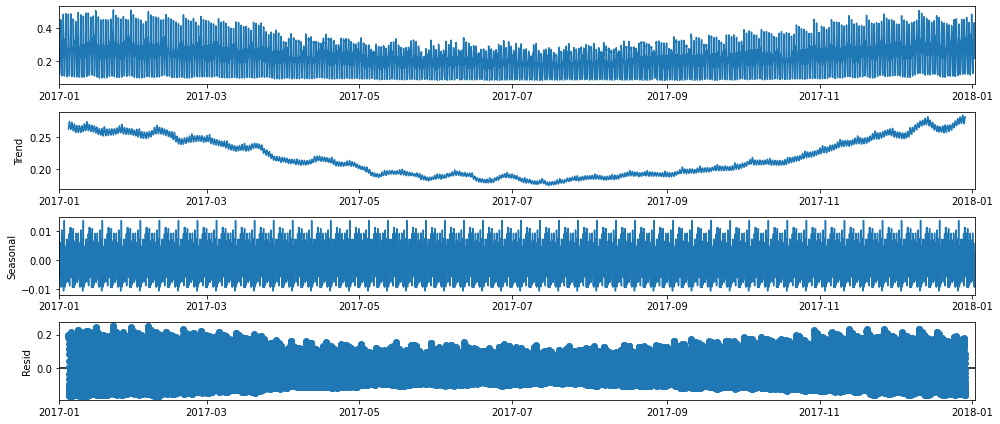

In [225]:
# Before applying the function to our table, we need to aggregate the demand for the whole population
print(f"The correct number of households is expected to be 10,385")
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(15, 5))
sd = seasonal_decompose(dmd.loc[:,['Demand_mean_kw']], freq=365)

fig = sd.plot()
fig.set_size_inches((14, 6))
# Tight layout to realign things
fig.tight_layout()
plt.show()

As we can see there is a multiplicative trend and an additive seasonality. The average demand seem to decrease from January to July before increasing again from July to December. This pattern can be explained by the change in temperature during these months by transferring from a warmer to colder climate/weather. The seasonality however is constant and we do not see any significant variation as shown in the plot below. Finally, the residual is more significant at both extreme (where demand is at it highest) and decrease when demand decrease respectively.

Text(0, 0.5, 'Mean Demand in kWh')

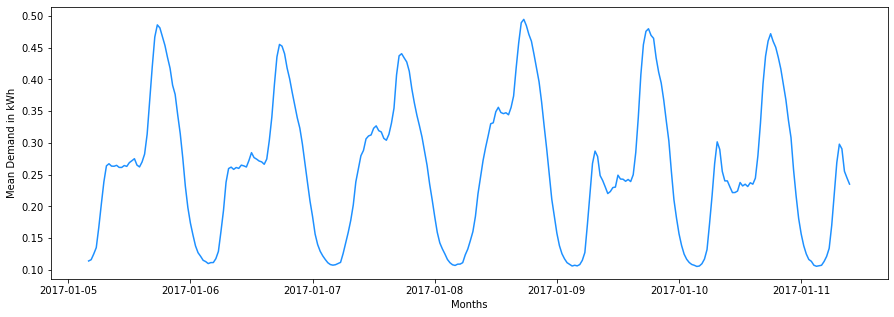

In [226]:
fig = plt.figure(figsize=(15, 5))
plot(dmd.Demand_mean_kw[200:500], color='dodgerblue')
plt.xlabel('Months')
plt.ylabel('Mean Demand in kWh')

We can now calculate the total demand during each 30 minute interval by multiplying by the total number of households 
(10385) and by 30 since we have the mean demand of the sample of households during the measurement period and need to convert it to the total energy consumed in the isles during the interval. One last step is to divide by 60 to convert the units from kWmin to kWh. The total average demand during each interval is added as a new column as shown below.

In [227]:
# we can now calculate the total demand during the 30 minute interval by multiplying by the total number of households 
# (10385) and 30 since we have the mean demand of the sample of households during the measurement period
final_tt_dmd_df['total_avg_demand'] = (final_tt_dmd_df.Demand_mean_kw * 10385 * 30) / 60
final_tt_dmd_df.head()

,final_wind_speed,Demand_mean_kw,N_households,total_avg_demand
Timestamp,,,,
2017-01-01 00:00:00,13.820000,0.220106,5428,1142.902923
2017-01-01 00:30:00,16.106667,0.205945,5429,1069.369982
2017-01-01 01:00:00,16.380000,0.189090,5429,981.849242
2017-01-01 01:30:00,17.083333,0.173118,5429,898.915577
2017-01-01 02:00:00,16.800000,0.159051,5429,825.870520


Finally, having all the data cleaned and prepared, we will create a function that models the power output generated given the specific wind speed collected at each interval. This function will be based on the observations made earlier on the turbine limitations and wind capacity calculated as following:

- Any wind speed that is below 4 m/s will return a power output of 0.
- Any wind speed above 25 m/s is also expected to generate 0 energy.
- Any wind speed between 4 and 12.5 m/s will generate an ouput of the cube of the wind speed time the wind capacity.
- Finally any wind speed above 12.5 m/s and below 25 m/s will generate 900 kWh.

By applying this function to the final wind speed, we obtain the following wind speed profile.

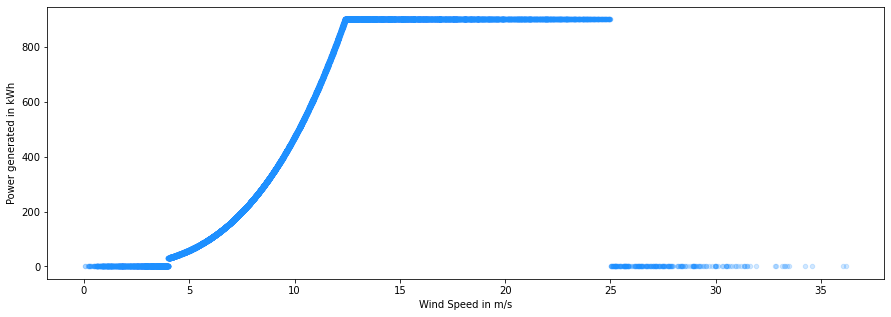

In [230]:
# Finally, we will create a function representative of the wind vs power profile to generate the power from the 
# wind speed collected at each provided day 

import warnings
warnings.filterwarnings("ignore")
random.seed(1)
# now that our data is normalised we can find the actual power output
def generate_power(wind):
    if wind < 4:
        return 0
    elif (wind >= 12.4) & (wind <= 25):
            return 900
    elif wind > 25:
        return 0 
    else:
        return (wind**3) * k_parameter 
    
def generate_noisy_power(wind):
    if wind < 4:
        return 0
    elif (wind >= 12.4) & (wind <= 25):
        if random.uniform(0,1) > 0.05:
            return 900 * random.uniform(0,1)
        else:
            return 900
    elif wind > 25:
        return 0 
    else:
        if random.uniform(0,1) > 0.05:
            return (wind**3) * k_parameter * random.uniform(0,1)
        else:
            return (wind**3) * k_parameter 
        
final_tt_dmd_df['power_output'] = final_tt_dmd_df['final_wind_speed'].apply(generate_power)
final_tt_dmd_df['noise_power_output'] = final_tt_dmd_df['final_wind_speed'].apply(generate_noisy_power)
final_tt_dmd_df['total_power_output'] = (final_tt_dmd_df.noise_power_output * 30 * 500* 0.5) / 60
final_tt_dmd_df.plot.scatter('final_wind_speed', 'power_output',alpha=0.2, figsize=(15, 5), c = 'dodgerblue')
plt.xlabel('Wind Speed in m/s' )
plt.ylabel('Power generated in kWh')
plt.show()

As you can see from the grapb above, the wind speed profile is too perfect to be true. In fact, it is way cleaner and different than the telemetry dataset visualised previously. This is because the first function generated does not include the probability of a wind turbine to default or the natural complication of real world machinery. Hence, we decided to create a more noisy function based on the same theory as the first one but including an additional line of code:

- Any wind speed that is below 4 m/s will return a power output of 0.
- Any wind speed above 25 m/s is also expected to generate 0 energy.
- Any wind speed between 4 and 12.5 m/s has an 80% chance to be noisy, if yes it will generate an ouput of the cube of the wind speed time the wind capacity times a random number between 0 and 1; else, it will generate an ouput of the cube of the wind speed time the wind capacity.
- Finally any wind speed above 12.5 m/s and below 25 m/s also has an 80% chance to be noisy, if yes it will generate an ouput of 900 kWh times a random number between 0 and 1; else, it will generate an ouput of 900 kWh.

We obtain the following new figure:

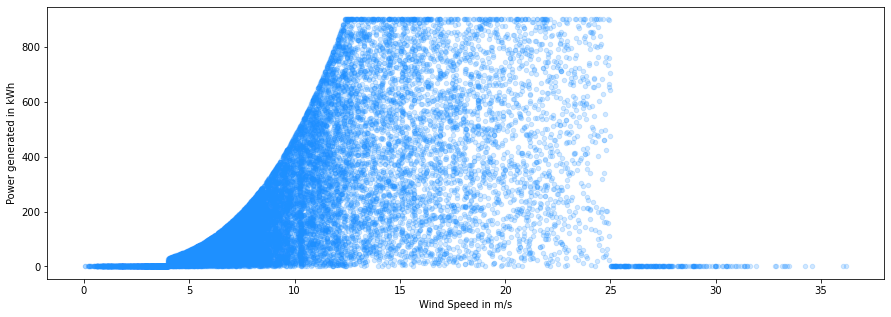

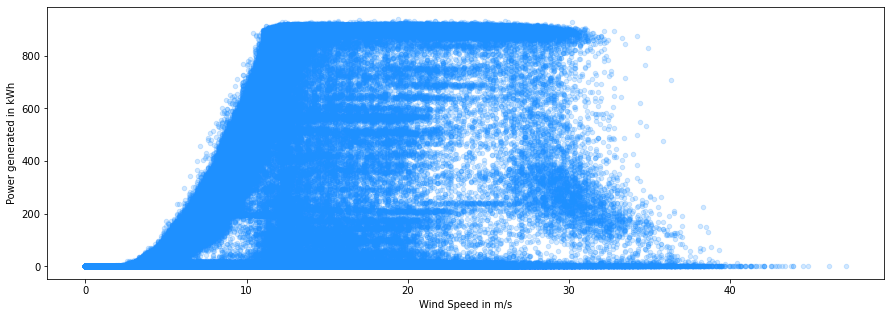

In [231]:
final_tt_dmd_df.plot.scatter('final_wind_speed', 'noise_power_output',alpha=0.2, figsize=(15, 5), c = 'dodgerblue')
plt.xlabel('Wind Speed in m/s' )
plt.ylabel('Power generated in kWh')
plt.show()
tt.plot.scatter('Wind_ms', 'Power_kw', alpha = 0.2, figsize=(15, 5), c = 'dodgerblue') # a lot cleaner!
plt.xlabel('Wind Speed in m/s' )
plt.ylabel('Power generated in kWh')
plt.show()

As we can see, by comparing the new wind profile (after introducing some noise) we obtain a very similar trend and dispersion to the provided telemetry data given. We can now use the mapped potential power generated based on each weather condition to calculate the curtailed energy being the culminate step of this section. The following subplots show the potential power output of 500 turbines and the demand of all the household from 2017 to 2018.

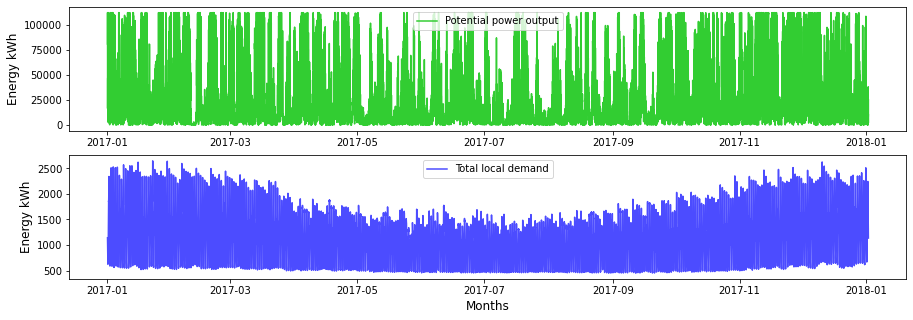

In [232]:
fig, axs = plt.subplots(2, figsize=(15,5))
axs[0].plot(final_tt_dmd_df.index, final_tt_dmd_df.total_power_output, color="limegreen")
axs[1].plot(final_tt_dmd_df.index, final_tt_dmd_df.total_avg_demand, color="blue", alpha = 0.7)

# set x-axis label
axs[1].set_xlabel("Months",fontsize=12)
# set y-axis label
axs[0].set_ylabel("Energy kWh",fontsize=12)
axs[1].set_ylabel("Energy kWh",fontsize=12)
axs[0].legend(['Potential power output'])
axs[1].legend(['Total local demand'])
plt.show()

### Calculate Curtailed Energy

As stated beforehand, the curtailed energy is calculated using the below equation, where potential energy represent sthe total energy outputted mapped using the wind speed data from the whole 500 turbines in Orkney in kWh, note that a 50% reduction was applied based on research and findings that showed that different wind locations would have different profiles and power output. annual demand represents the total average energy consumed by the 10,385 households from the demand data and annual export is the energy exported to the mainland that is calculated as its capacity of 40 MW times 365 (days in a year) times 24 (hours in a day) times 1000 to convert to kW. Note that power generated is not constantly exported to the mainland at full capacity and hence we applied a 20% reduction to it.

$ annual \; curtailed = potential \; energy - annual \; demand - annual \; export$

In [233]:
total_tt_dmd_df = final_tt_dmd_df.loc[:, ['total_avg_demand', 'total_power_output']]
annual_dmd_tt = total_tt_dmd_df.sum()
annual_demand = annual_dmd_tt[0]
potential_energy = annual_dmd_tt[1]
annual_export = 40*(10**3)*365*24*0.8
annual_curtailed = potential_energy - annual_demand - annual_export

In [234]:
print(f"Every year, {annual_curtailed}  Watts are curtailed in the Orkney Islands")

Every year, 173091618.827  Watts are curtailed in the Orkney Islands


In [237]:
print(f"Every year, {round((annual_curtailed/potential_energy)*100, 3)}% of the energy produced by wind turbines are curtailed in the Orkney Islands") 

Every year, 35.346% of the energy produced by wind turbines are curtailed in the Orkney Islands


### Reduction in curtailement at different DR

The next section of this report investigates whether different DR penetretation level significantly decrease the curtailement in Orkney islands and at what extent. In order to calculate the reduction in curtialement at different DR, we will start by calculating the energy consumption of each device. We will extract the 2017 to 2018 telemetry data without filtering for records where the set point is below 900, and we will aggregate the data in a 30 minute interval to reduce computation time. The next step is to add a new column to the telemetry data that specify whether the energy is being curtialed or not, i.e any recording with a setpoint below 900 is assigned a value of 1 (as being curtailed) and anything else is assigned a value of 0 (as not being curtailed). This new column will be used later on as a guide to calculate the energy consumption per device. The last step here is to initialise the heat smart device feature that will be used in the calculations: An average smart device charges by 3.3 kW, has a capacity of 21.3 kWh $\times$ 60 min/h = 916.8 kWmin, and discipates 1.5 kW of heat energy (Dimplex, n.d.).

We will be tracking the energy consumed, charge and heat released of one device throughout the whole algorithm:

In [246]:
# Create a variable to indicate whether curtailed or not
tt_12 = tt[(tt.index >= ('2017-01-01 00:00:00')) & (tt.index < '2018-01-02 00:00:00')]
tt_13 = tt_12.groupby(pd.Grouper(freq='30Min')).aggregate(numpy.mean)

tt_13['Curtailed'] = np.where(tt_13['Setpoint_kw'] < 900, 1, 0) # 1 if curtailed, 0 if not

charging = 3.3
discharge = 1.5 
capacity = 21.3 * 60

curtailed = tt_13['Curtailed']
current_charge = 0 # track charge during an interval
energy_consumed = 0 # track energy consumed from charging the system during an interval
heat_released = 0 # track heat dissipated (discharge) during an interval
print(f'The current charge during an interval is initialised as {current_charge}')
print(f'The energy consumed from charging the system during an interval is initialised as {energy_consumed}')
print(f'The heat released (discharged) during an interval is initialised as {heat_released}')

The current charge during an interval is initialised as 0
The energy consumed from charging the system during an interval is initialised as 0
The heat released (discharged) during an interval is initialised as 0


#### Consumption per Device

Since all the parameters are now initialised, we can go ahead and generate a function that will update the charge, energy consumed and heat released of one device depending of the state of a record (being curtailed or not) and the season (winter or summer). The function loops through the records extracted from the telemetry data to gradually update the value initialised beforehand. For each record, the following statements are applied:
- If the record involves energy curtailement, and the current charge of the device summed with the charging value of a device times 30 (since we aggregated the data by 30 minute interval) is lower or equal to the device capacity, the energy consumed and current charge of the device increase by the charging parameter times 30 minutes. i.e. if the storage is full/will be full, the energy consumed and charge are summed with the gained energy from charging respectively.
- If the record involves energy curtailement but  the current charge of the device summed with the charging value of a device times 30 is higher to the device capacity, meaning that the additional storage will excede the capacity of the device, the energy consumed by the device increase available energy left between the capacity and current charge of the device. The device current charge also charge up to max capaxity.
- If the record does not involve energy curtailement, and the current charge of the device minus the discharge value of a device times 30 (since we aggregated the data by 30 minute interval) is higher or equal to 0, the heat released by the device increases by the discharge parameter times 30 minutes and the current charge decreases by this disharge times 30. i.e. If the charge of the device has enough capacity, the heater discharges during non-curtailment and dissipates heat, increasing the heat released variable and reducing its charge.
- Finally, If the record does not involve energy curtailement, but the current charge of the device minus the discharge value of a device times 30 lower than 0 (no charge left to generate heat), the heat released by the device increases by the current charge of the device only and the current charges becomes zero (all the chare have been converted to heat).

We assumed that the same energy was consumed by the smart heater for both the summer and winter months and the total energy consumed by one device is displayed below (since the calculation s were made in kWmin we divided the final result by 60 to get it in kWh)

In [247]:
# months were chosen based on higher and lower than average demand from the graph above
winter = [1,2,3,4,5,9,10,11,12]
summer = [6,7,8]

for i in range(0, len(curtailed)): # if the time is during winter
    
    if tt_13.index.month[i] in winter:
        if curtailed[i] == 1: 
            if current_charge + charging*30 <= capacity: # if the storage is full/ will be full
                energy_consumed += charging*30 # energy consumed is the gained energy from charging
                current_charge += charging*30 # new charge will be old + new
            else: # if the additional storage will excede the capacity
                energy_consumed += (capacity - current_charge) 
                current_charge = capacity 
        
        elif curtailed[i] == 0:  
            if current_charge - discharge*30 >= 0 : # if the storage is full/ will be full
                heat_released += discharge*30
                current_charge -= discharge*30 # new charge will be old + new
            else: 
                heat_released += current_charge
                current_charge = 0 

# we can now determine the energy consumed in summer by finding the fraction of summer demand over winter demand from
# the provided data, and then apply this rate on the energy consumed in winter 
summer_dmd = dmd[dmd.index.month.isin(summer)]['Demand_mean_kw'].sum() * 10385
winter_dmd = dmd[dmd.index.month.isin(winter)]['Demand_mean_kw'].sum() * 10385
rate_sum_wint = summer_dmd/ winter_dmd
consumed_winter = energy_consumed
consumed_summer = consumed_winter 
total_consumed_one_device = (consumed_winter + consumed_summer)/60
print(f'The total energy consumed by one device is expected at {total_consumed_one_device} kWh')

The total energy consumed by one device is expected at 2478.3 kWh


### Curtailement Reduction

Having calculated the total expected energy consumed by one heat smart device, we can determine the expected curtailement reduction at different DR penetration. We assumed a DR penetration rate that ranges from 0 to 100% with 10% interval. For each level of penetration we calculated both the total energy consumed by the devices as well as the new amount of curtailed energy annually. By assuming one device by households, we calculated the above parameters for each percentage of household acquiring the device; total energy consumed by devices is calculated by multiplying the total number of devices live times the consumption of one device (2478.3 kWh), whereas the new curtialed energy was calculated by subtracting the annual amount curtailed (calculated in the first section) by the total amount consumed by the devices during a specific penetration rate.

Finally, we displayed the variation of energy consumed by device in kWh and the change in % of energy curtailed t different DR penetration as shown in the figure below.

In [1627]:
DR = np.arange(0, 1, 0.1).tolist()
total_consumed = []
new_curtailed = []
for v in range(len(DR)):
    n_devices = DR[v] * 10385
    total_consumed.append(n_devices * total_consumed_one_device)
    new_curtailed.append(annual_curtailed - total_consumed[v])
DR_perc = [i*100 for i in DR]

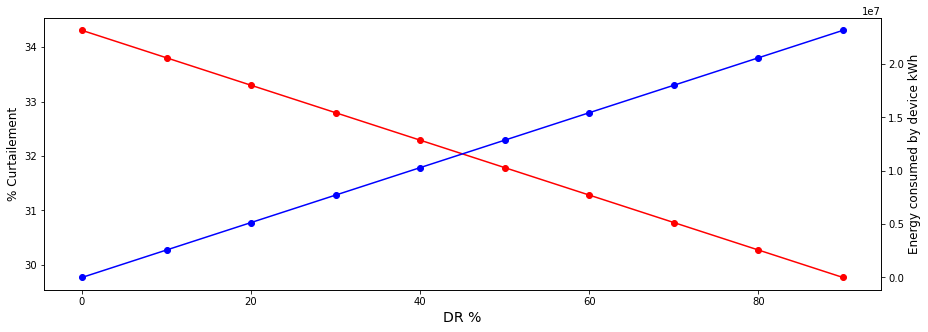

In [1628]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(DR_perc, (new_curtailed/potential_energy)*100, color="red", marker="o")
# set x-axis label
ax.set_xlabel("DR %",fontsize=14)
# set y-axis label
ax.set_ylabel("% Curtailement",fontsize=12)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(DR_perc, total_consumed,color="blue",marker="o")
ax2.set_ylabel("Energy consumed by device kWh",fontsize=12)
plt.show()
fig.savefig('hjg.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

## References

- https://www.oref.co.uk/orkneys-energy/wind/
- https://localenergy.scot/wp-content/uploads/2022/02/HSO-report-Final-Version-for-LECF-Nov-2020.pdf
- Dimplex. (n.d.) Quantum Heater QM150. https://www.dimplex.co.uk/product/quantum-heater-qm150 [Accessed 26th May 2022]
- Compton, D. et al. (2020) Heat Smart Orkney (HSO) Project. Heat Smart Orkney Ltd. https://localenergy.scot/wp-content/uploads/2022/02/HSO-report-Final-Version-for-LECF-Nov-2020.pdf

- National Records of Scotland. (2020) Household Estimates. https://www.nrscotland.gov.uk/statistics-and-data/statistics/statistics-by-theme/households/household-estimates [Accessed on 30th May 2022]

- UK Department for Business, Energy & Industrial Strategy. (2022) Guidance: Boiler Upgrade Scheme. https://www.gov.uk/guidance/check-if-you-may-be-eligible-for-the-boiler-upgrade-scheme-from-april-2022 [Accessed on 31st May 2022]

- UK Department for Business, Energy & Industrial Strategy. (2022) Statistical data set: Annual domestic energy bills. https://www.gov.uk/government/statistical-data-sets/annual-domestic-energy-price-statistics [Accessed on 30th May 2022]

	

